I start modeling city level spread dynamic from simple SIR model
https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics
$$
\begin{align}
& \frac{dS}{dt} = - r_0 I S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I, \\[3pt]
&R = 1-S-I,\\[3pt]
&I(0)=I_0,\,S(0)=1-I_0
\end{align}
$$
Here the city population being normalized to 1. 

$S$ - The proportion of the of susceptible population

$I$ - The proportion of the of infectious population

$R$ - The proportion of the of removed (and immune) or deceased population

The time unit is equal to mean disease recovery (or death) duration and for COVID-19 is something like 15-17 days.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scst
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.ticker as ticker
plt.rc('legend',fontsize=12, handlelength=2) # using a size in points

plt.style.use('seaborn-darkgrid')

I decided to perform modeling for 8 time units.

In [2]:
modeling_period=8.0
t_step=0.005
m_t=np.arange(0.0, modeling_period+t_step, t_step,dtype=np.float64)
n_steps=len(m_t)-1

Now define  parameters,equation and solve it

In [3]:
def SIR(y,t,r0):
    S,I=y[0],y[1]
    dS = -r0*I*S
    dI= -dS - I
    return [dS, dI]

r0,I0=7.0,0.0001
SIR_y0= [1.0 -I0, I0]

SIR_sol = odeint(SIR,SIR_y0, m_t,(r0,)).T
S,I,R=SIR_sol[0],SIR_sol[1],1.0-SIR_sol[0]-SIR_sol[1]

Let's look at the result

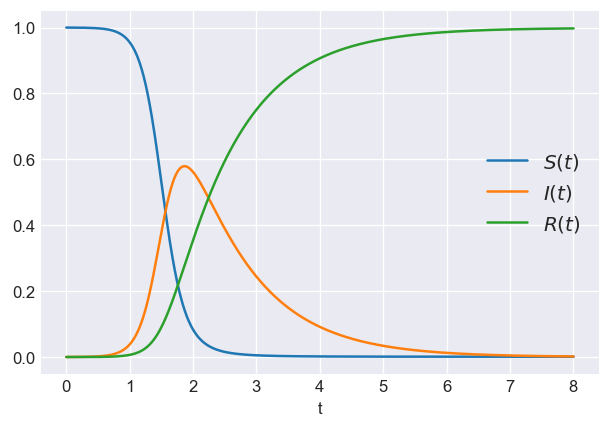

In [4]:
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S , color='C0', label=f'$S(t)$')
plt.plot(m_t, I, color ='C1',  label=f'$I(t)$')
plt.plot(m_t, R, color='C2',  label=f'$R(t)$')
plt.xlabel('t')
plt.legend()
plt.show()   

SIR model above suggests homogeneity of the population. And the model doesn't explain the fact that COVID-19 infection rate reaches maximum after around 5%-15% of the population being ever infected and then substantially slows down.  This was observed in many cities around the world. In many cases it can be explained by public measures to limit the disease spread. But the roughly same picture was in countries where there was no public measures or the measures was inefficient. 

inhomogeneity of the population could give the explanation. Indeed, individuals are different in the intensity of contacts with other people (social inhomogeneity), and in ability to catch the disease (biological inhomogeneity). Social and biological are together forming total population inhomogeneity in ability to catch the disease. As a result some persons are much more exposed to the disease catching (and thus transmitting) and these persons catch the disease among the first and become immune (at least for some time). It is a reason why average disease spreading ability drops in time.

To deal with inhomogeneity we start from even more simple model SI, where susceptible at some moment becomes infectious and leave infectious for ever. For this model at first I suggest some reasonable inhomogeneity dealing technique (IDT) and next propose more speculative one. The second IDT is much more simple to implement and I will show, that although having more speculative nature it is produces almost the same results as the first one. So it is kind of digital approximation of the reasonable IDT and will be used in the later modeling.  

I use lognormally distributed random variable $X \sim LogN(\mu_0,v_0)$ to model the population ability to get the disease, so $\log(X) \sim N(\mu_0,v_0)$, where $v_0$ - variance of $\log(X)$. 
$$f_{X}(x)=f_{X}(x,\mu_0,v_0)= \frac {1} {\sqrt{2\pi\,v_0}} \frac{1}{x} \exp\left( -\frac{(\ln x-\mu_0)^2}{2 v_0} \right)$$
So, for now log normally distributed variable $X$ describe the whole population ability to catch  the disease AND IT DOES NOT CHANGE IN TIME.

Log normal distribution is quite common in describing social and biological processes. One of its main feature is large range of values. It makes separate consideration of superspread events unnecessary because heavy distribution tail covers superspread events.



Let $s(x,t)$ is the portion (at moment t) of susceptible population with ability to catch the disease $x$. At the beginning it is equal to one ($s(x,0)=1$) and moves down to zero in time as more and more individuals get infected. The total portion of susceptible population is getting by integrating over x distribution:
$$S(t)=\int_0^{\infty} s(x,t)f_X(x)dx$$

The part of $s(x,t)$ becoming infectious at the interval $t,t+dt$ is proportional to $s(x,t)$ itself, ability to catch and spread the disease $x$, and total portion of infectious population:
$$ds(x,t)=-\alpha x\,s(x,t)I(t)dt$$
where
$$I(t)=1-S(t)=1-\int_0^{\infty} s(x,t)f_X(x)\,dx$$

Finally
$$\frac{ds}{dt}=-\alpha\,x\,s\,\left(1-\int_0^{\infty} s(x,t)f_X(x)\,dx\right)$$

Let $s(x,t)=e^{-x\,u(t)}$ then we have
$$-x\,s\,\frac{du(t)}{dt}=-\alpha\,x\,s\,\left(1-\int_0^{\infty} e^{-x\,u(t)}f_X(x)\,dx\right)$$
or
$$\frac{du}{dt}=\alpha\,\left(1-\int_0^{\infty} f_X(x)e^{-x\,u}\,dx\right)$$

The integral on the right is the Laplace transform of the $X$ distribution https://en.wikipedia.org/wiki/Laplace_transform#Formal_definition
$$\mathcal{L}(u)= \int_0^{\infty} f_X(x)e^{-x\,u}\,dx $$

so we get the equation looking rather simple:
$$\frac{du}{dt}=\alpha\,\left(1-\mathcal{L}(u)\right)$$
$$u(0)=\mathcal{L}^{-1}(S(0)),\:S(t)=\mathcal{L}(u(t)),\: I(t)=1-S(t)$$

The problem is the Laplace transform of the lognormal distribution 
$$\mathcal{L}(u,\mu_0,v_0)= \int_0^{\infty}e^{-x\,u} f_X(x,\mu_0,v_0)dx=\\ \frac {1} {\sqrt{2\pi\,v_0}} \int_0^{\infty}  \frac{1}{x}\exp(-x\,u) \exp\left(-\frac{(\ln x-\mu_0)^2}{2 v_0}\right) dx$$
is not easily computable function.

Let $M(\mu_0,v_0)=\exp(\mu_0+v_0/2) $ is expectation of lognormal variable $X \sim LogN(\mu_0,v_0)$

It can be shown that for any for any $a$
$$\mathcal{L}(u,\mu_0,v_0)=\mathcal{L}(u\,e^a,\mu_0-a,v_0)$$
also
$$ \frac{\mathcal{L}(u,\mu_0,v_0)}{du}=-M(\mu_0,v_0)\mathcal{L}(u,\mu_0+v_0,v_0)=-M(\mu_0,v_0)\mathcal{L}(u\,e^{v_0},\mu_0,v_0)$$

So we get forward differential equation for $\mathcal{L}(u)$
$$\frac{d\mathcal{L}(u)}{du}=-M\,\mathcal{L}(u\,e^{v_0})$$

But all these things does not make us any closer to calculation of Laplace transform of the lognormal distribution. Yet what these equations does allow us — they are allowed us to check the quality of different approaches to the calculation. 

First I use this approximation https://en.wikipedia.org/wiki/Log-normal_distribution#Characteristic_function_and_moment_generating_function

$$\mathcal{L}^*(u,\mu_0,v_0)=\frac{\exp\left(-\frac{W(\theta)(W(\theta)+ 2)}{2v_0} \right)}{\sqrt{1+W(\theta)}}$$
where
$$\theta=u\,v_0\,e^{\mu_0}$$

and $W$ is the Lambert W function.

Let's check how good the approximation is by defining the function for checking the ratio
$$-\frac{d\mathcal{L}^*(u,\mu_0,v_0)/du}{M\,\mathcal{L}^*(u,\mu_0+v_0,v_0)}$$ 
it should be close to 1.

In [5]:
def check_ratio(L,u,mu0,v0):
    u_step=(u[-1]-u[0])/(len(u)-1)
    d=L(u,mu0,v0)
    deriv=(d[:-1]-d[1:])/u_step
    M=np.exp(mu0+0.5*v0)
    V=M*L(u,mu0+v0,v0)
    return 0.5*(u[:-1]+u[1:]),2.*deriv/(V[:-1]+V[1:])  

Also define Laplace transform approximation function

In [6]:
def LaplTrLNApprox(u,mu0,v0):
    theta=u*v0*np.exp(mu0)
    W=np.real(scsp.lambertw(theta))
    return np.exp(-W*(W+2)/(2*v0))/np.sqrt(1+W)


And now we can make the check:

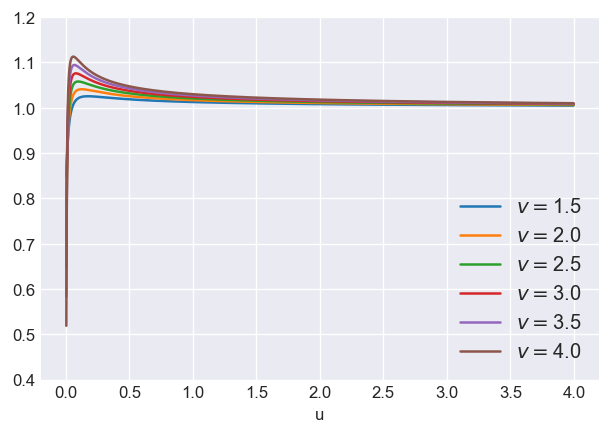

In [7]:
mu0=1.5
v_step=0.5
v_min=1.5
v_max=4.0
v_range=np.arange(v_min,v_max+v_step, v_step,dtype=np.float64)
u_step=0.005
u_min=0.0
u_max=4.0

u_range=np.arange(u_min,u_max+u_step, u_step,dtype=np.float64)

fig, ax = plt.subplots(dpi=120)
for v0 in v_range:
    u,r=check_ratio(LaplTrLNApprox,u_range,mu0,v0)
    plt.plot(u, r, label=f'$v=${v0}')
plt.xlabel('u')
ax.set_ylim([0.4,1.2])
plt.legend(loc='lower right')
plt.show()


Let's take closer look what happens nearby 0.

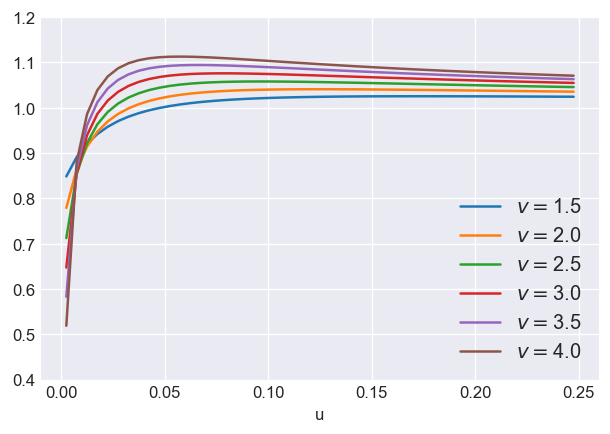

In [8]:
u_mid=0.25
u_subrange=np.arange(u_min,u_mid+u_step, u_step,dtype=np.float64)
fig, ax = plt.subplots(dpi=120)
for v0 in v_range:
    u,r=check_ratio(LaplTrLNApprox,u_subrange,mu0,v0)
    plt.plot(u, r, label=f'$v=${v0}')
plt.xlabel('u')
ax.set_ylim([0.4,1.2])
plt.legend(loc='lower right')
plt.show()

So the approximation is quite good for $u>1$, but nearby 0 it is unsatisfactory. And the range nearby 0 is very important for modelling because it is the beginning of the disease and small difference in the infection level will be amplified.

Now we define the Laplace transform by direct integrating 

In [9]:
def LaplTrLNDirect(u,mu0,v0):
    max_exp=744.0 # np.exp(-max_exp) - minimal double value to calculate without overflow
    a=max_exp*np.exp(-(np.sqrt(2.0*max_exp*v0)+mu0)/2.0)
    def LLN(v): #calculates the Laplace transform for scalar v
        if v==0:
            return np.sqrt(2.0*np.pi*v0)
        
        def F(y): #integrand
            s=np.exp(y+mu0)*v+0.5*y**2/v0
            return np.exp(-s)

        lb=-np.sqrt(2.0*max_exp*v0) #low integration bound
        # for smaller values integrand will be calculated as zero
        # anyway due to overflow  
        ub=3.*np.log(max_exp/(v+a))-mu0 #upper integration bound
    
        # for bigger values integrand will be calculated as zero
        # anyway due to overflow  
        if lb>=ub:
            return 0.0
        return quad(F,lb,ub,epsabs=1.0e-9, epsrel=1.0e-9)[0] #integration
    m=1.0/np.sqrt(2.0*np.pi*v0)
    return m*np.vectorize(LLN,otypes=[float])(u)


It is really much more accurate but also much slower

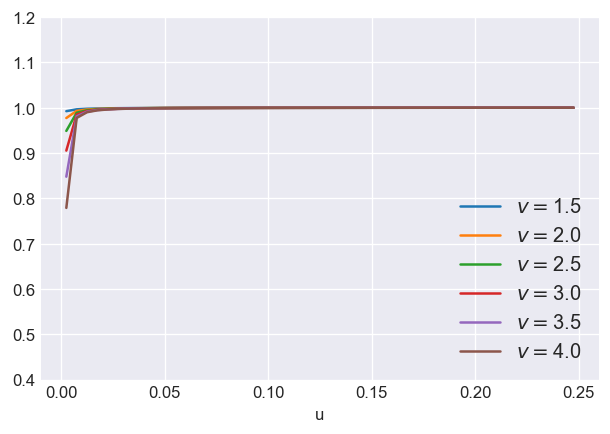

In [10]:
fig, ax = plt.subplots(dpi=120)
for v0 in v_range:
    u,r=check_ratio(LaplTrLNDirect,u_subrange,mu0,v0)
    plt.plot(u, r, label=f'$v=${v0}')
plt.xlabel('u')
ax.set_ylim([0.4,1.2])
plt.legend(loc='lower right')
plt.show()

Below alternative much faster and more simple to implement inhomogeneity dealing technique.

Previously we use lognormally distributed variable $X$ to model the WHOLE population ability to catch the disease. The distribution was fixed and all dynamics was described by $s(x,t)$ - the portion  of susceptible population with ability to catch and spread the disease $x$. Now we use lognormally distributed variable $X_s(t)$ to model SUSCEPTIBLE population ability to catch the disease and also value of $S(t)$ - the proportion of the of susceptible population (of all the population)

Suppose at a time $t$ we have log normal $X_s$ distribution with parameters $\mu(t)=E[\log(X_s(t))]$ and $v(t)=Var[\log(X_s(t))]$. Let's calculate new values $\mu(t+dt)=E[\log(X_s(t+dt))]$ and $v(t+dt)=Var[\log(X_s(t+dt))]$ at moment $t+dt$. Of cause even if we calculate the values correctly the distribution at moment $t+dt$ will loose lognormality BUT WE SUPPOSE THAT THE DISTRIBUTION SOMEHOW ADJUST ITSELF TO BECOME LOGNORMAL WITH NEW PARAMETERS $\mu(t+dt)$ and $v(t+dt)$.  

Let now $s(x,t)$ is the "density" of portion of susceptible population namely: the susceptible portion of total population having (at a time t) ability to catch and spread the disease in the interval $[x,x+dx]$ is $s(x,t)dx$ and $s(x,t)=S(t)\cdot f_{X_s}(x)$:
$$f_{X_s}(x,t)=f_{X_s}(x,\mu(t),v(t))= \frac {1} {\sqrt{2\pi\,v}} \frac{1}{x} \exp\left( -\frac{(\ln x-\mu)^2}{2 v} \right)$$

Vice versa 
$$f_{X_s}(x,t)=s(x,t)/S(t)$$
$$S(t)= \int_0^{\infty}s(x,t)dx$$




We start from calculation $s(t+dt)$ assuming that individuals get infected with probability equal to the product of $dt$,$x$ and some coefficient $c$ for the infection "intensity":
$$s(x,t+dt)=s(x,t)-c x\, s(x,t)dt=S(t)f_{X_s}(x,t)(1-c x\, dt)$$
integrating it over x we get
$$S(t+dt)= \int_0^{\infty}S(t)f_{X_s}(x,t)(1-c x\, dt)\,dx=S(t)(1-c E_{X_s(t)}[x]dt)=S(t)(1-c M\, dt)$$
where $M=M(t)=M(\mu,v)=\exp(\mu+v/2)$ and
$$f_{X_s}(t+dt)=s(x,t+dt)/S(t+dt)=\frac{f_{X_s}(t)(1-c x\, dt)}{1-c M\, dt}$$
so
$$\mu(t+dt)=E_{X_s(t+dt)}\,[\ln(x)]=\frac{E_{X_s(t)}[(1-c x\,dt)\ln(x)]}{1-c M dt}=\frac{E_{X_s(t)}[\ln(x)]-c E_{X_s(t)}[x\ln(x)]\,dt}{1-c M dt}$$

$$=\mu(t)-c M(\mu,v) v(t)\,dt +o(dt)$$
also omitting some math

$$v(t+dt)=v(t)-c M(\mu,v) v^2(t)\,dt +o(dt) $$

As we have assumed above $f_{X_s}(t+dt)$ somehow adjust itself to become lognormal $X_s(t+dt)\sim LogN(\mu(t+dt),v(t+dt))$ and we can apply the above procedure to step further on another $dt$. Thus, the distribution $ X_s (t) $ evolves while remaining lognormal with the parameters $ \mu (t) $ and $ v (t) $, which change in accordance with the equations:
$$\frac{d S}{dt}=-c  M S$$
$$\frac{d\mu}{dt}=-c M v$$
$$\frac{d v}{dt}=-c M v^2$$
Coefficient  $c$  for infection "intensity" is just $\alpha I=\alpha (1-S)$ (remember, we're still discussing SI model) so finally we get the system:
$$\frac{d S}{dt}=- \alpha M (1-S)S$$
$$\frac{d\mu}{dt}=- \alpha M (1-S)v $$
$$\frac{d v}{dt}=-\alpha M (1-S)v^2 $$

If compared to SIR model this model suggest non-constant $r_0$. Now $r_0$ changes in time $r_0(t)=\alpha M(t)$ where $\alpha$ is a constant calculated as $\alpha =r_0(0)/M(0)$ so
$$r_0= \alpha\, M(\mu,v)$$
$$\frac{d S}{dt}=- r_0 (1-S)S$$
$$\frac{d\mu}{dt}=- r_0 (1-S)v $$
$$\frac{d v}{dt}=-r_0 (1-S)v^2 $$
$$S(0)=1-I_0,\:\mu(0)=\mu_0,\:v(0)=v_0,\: \alpha=\frac{r_0(0)}{M(\mu_0,v_0)}$$



Let's compare approach with direct calculation of the Laplace transform (or its approximation using Lambert W function) and evolving lognormal distribution (the alternative).

For the first one we need a function to calculate initial value of $u$

In [11]:
def M(mu,v):return np.exp(mu+0.5*v)

def get_u0(LLN,S0,mu0,v0,guess=3.0e-03):
    '''
    calculates u_0 given S_0 and the distribution parameters
    LLN - function to calculate the Laplace transfom of lognormal variable
    mu0,v0 - parameters of the disribution namely
    expectation and variance of the lognormal variable logarithm 
    '''
    def cost_f(v):
        if v<=0:
            vM=v*M(mu0,v0)
            f=(1.0-vM+vM**2*np.exp(v0)) #the minimize function can pass a negative v  
        else:
            f=LLN(v,mu0,v0)
        return (f-S0)**2
    m=minimize(cost_f,guess,method='Powell')
    return np.atleast_1d(m.x)[0]

Next define ODE and function to integrate it returning $I$

In [12]:
def get_I(LTLN,mu0,v0):
    '''
    calculates I for SI model with lognormal population inhomogeneity
    LTLN - function to calculate the Laplace transfom of lognormal variable
    mu0,v0 - parameters of the disribution namely
    expectation and variance of the lognormal variable logarithm 
    '''
    α=r0/M(mu0,v0)
    def ODE(y,t):
        u=y[0]
        du = α*(1-LTLN(u,mu0,v0))
        return [du]    
    
    y0= [get_u0(LTLN,1.0-I0,mu0,v0)]
    sol = odeint(ODE,y0, m_t).T
    S=LTLN(sol[0],mu0,v0)
    return 1.0-S

The same for the alternative method

In [13]:
def get_I_alt(mu0,v0):
    α=r0/M(mu0,v0)
    def ODE(y,t):
        S,mu,v=y[0],y[1],y[2]

        minus_r0_mult_I=-α*M(mu,v)*(1.0-S)

        dS = minus_r0_mult_I*S
        dmu = minus_r0_mult_I*v
        dv = dmu*v
        return [dS, dmu, dv]
    y0= [1.0 - I0,mu0,v0]
    sol = odeint(ODE,y0, m_t).T
    return 1.0-sol[0]



Now compare the results

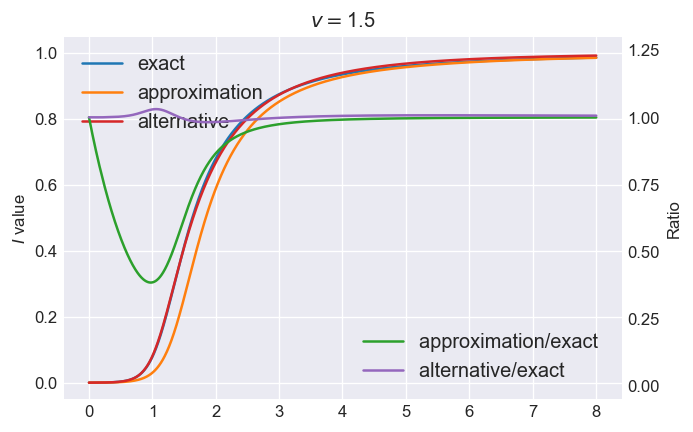

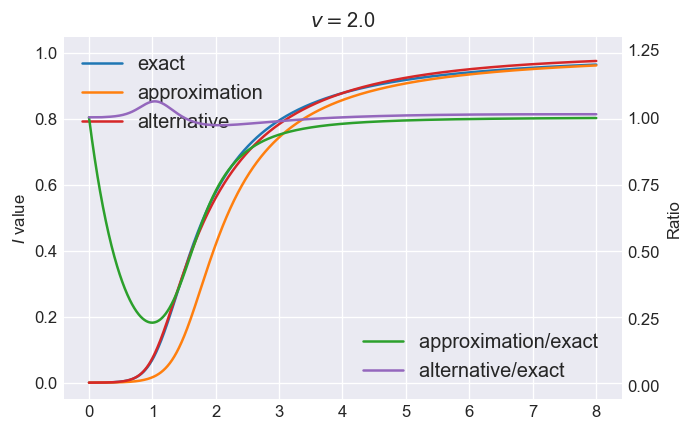

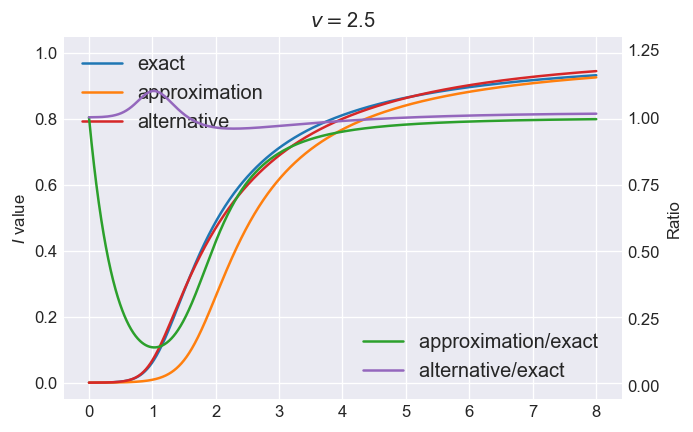

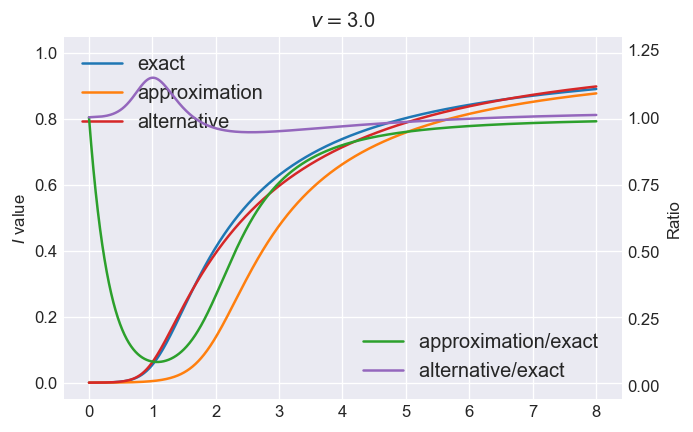

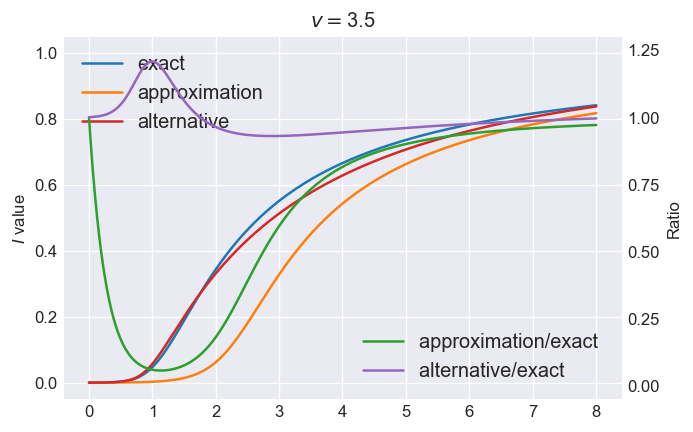

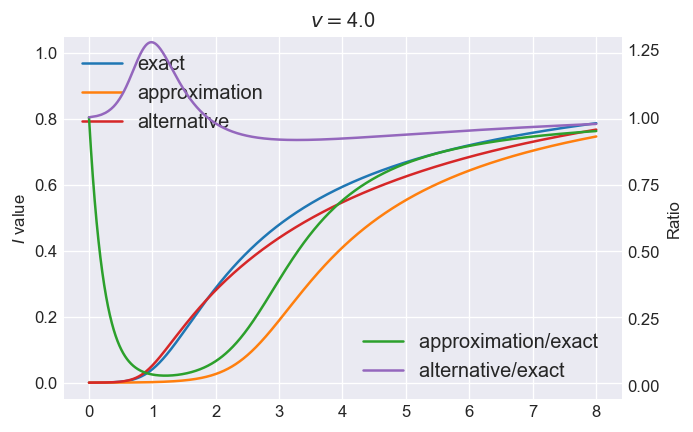

In [14]:
for v0 in v_range:
    fig, ax = plt.subplots(dpi=120)
    I_exact=get_I(LaplTrLNDirect,mu0,v0)
    I_approx=get_I(LaplTrLNApprox,mu0,v0)
    I_alt=get_I_alt(mu0,v0)
    plt.plot(m_t, I_exact, color='C0', label=f'exact')
    plt.plot(m_t, I_approx,color='C1', label=f'approximation')
    plt.plot(m_t, I_alt,color='C3', label=f'alternative')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.set_ylim([-0.05,1.05])
    ax.set_ylabel(f'$I$ value')
    plt.legend(loc='upper left')
    ax2 = ax.twinx()
    plt.plot(m_t, I_approx/I_exact, color='C2', label=f'approximation/exact ') 
    plt.plot(m_t, I_alt/I_exact, color='C4', label=f'alternative/exact ') 
    ax2.set_ylim([-0.05,1.30])
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax2.grid(False)
    ax2.set_ylabel('Ratio')
    plt.legend(loc='lower right')
    plt.title(f'$v=${v0}')
    plt.xlabel(f'$t$')
    plt.show()   

Thus, the alternative method although uses suspicious hypothesis of somehow adjusted log normal distribution gives quite close result to exact solution.

Exact solution uses slow calculated Laplace transform moreover I can not to imaging how to implement it many environments for example in pymc3 Bayesian inference.

Now let's apply the approach to SIR model. Modified SIR equations are
$$\begin{align}
& r_0= \alpha\, M(\mu,v), \\[3pt]
& \frac{d S}{dt}=- r_0 I\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{d\mu}{dt}=- r_0 I\,v, \\[3pt]
& \frac{d v}{dt}=-r_0 I\,v^2, \\[3pt]
&R = 1-S-I
\end{align}$$
$$I(0)=I_0,\:S(0)=1-I_0,\:\mu(0)=\mu_0,\:v(0)=v_0,\: \alpha=\frac{r_0(0)}{M(\mu_0,v_0)}$$

In [15]:
def getSIRdS(r0,I0,v0):
    α=r0/M(0.0,v0)
    
    def ODE(y,t):
        S,I,mu,v=y

        minus_r0_mult_I=-α*M(mu,v)*I

        dS = minus_r0_mult_I*S
        dI = -dS - I
        dmu = minus_r0_mult_I*v
        dv = dmu*v
        return [dS, dI, dmu, dv]
    
    y0=[1.0-I0,I0,0.0,v0]
    
    sol = odeint(ODE,y0, m_t).T
    dS, _,_,_=ODE(sol,m_t)
    S,I,R=sol[0],sol[1],1.0-sol[0]-sol[1]
    return S,I,R,-dS

The function above calculates $S$,$I$,$R$ values and also infection rate $|dS|$.

We use 0.001 as initial infectious portion $I_0$. To get $r_0$ for COVID_19 we uses the fact that it was reported around 30% daily growth in initial stage. Combining with, say, 16 days mean disease recovery (or death) duration it gives us a value for $r_0$.

$$r_0=\ln(1.3)\cdot 16 \approx 4.2$$

We need only to set up initial $v$ - $v_0$. And we guess it to 2.5.

To check $v_0$ values we use a function calculating the ratio of top 10% bound to low 10% bound given lognormal distribution with parameter $v_0$.
$$r=\exp\left((\Phi(0.9)-\Phi(0.1))\cdot\sqrt{v_0}\right)$$
where $\Phi()$ - the function reverse to standard normal PDF.

For guessed $v_0=2.5$ the range is

In [16]:
range0901=scst.norm.ppf(0.9)-scst.norm.ppf(0.1)
r=np.exp(range0901*np.sqrt(2.5))
print(f'ratio of top 10% to low 10% for v0=2.5 is {r}')

ratio of top 10% to low 10% for v0=2.5 is 57.548144094658774


I also divide total ratio on social part $r_s$ and biological part $r_b$ assuming $r_s$ and $r_b$ having joint log normal distribution and independent of each other. We will consider equally divided $r_s$ and $r_b$ version and version with predefined $r_s$ equal say 20.0

For equally divided 
$$r_s=r_b=\exp\left(\frac{(\Phi(0.9)-\Phi(0.1))\cdot\sqrt{v_0}}{\sqrt{2}}\right)$$
For given $r_s$
$$r_b=\exp\left(\sqrt{(\Phi(0.9)-\Phi(0.1))^2\cdot v_0-r_s^2}\right)$$

In [17]:
def get_range(v0,rs=None):
    temp=range0901**2*v0
    r=np.exp(np.sqrt(temp))
    if rs is None:
        rs=np.exp(np.sqrt(0.5*temp))
        rb=rs
    else:
        rb=np.exp(np.sqrt(temp-np.log(rs)**2))
    return r,rs,rb

r,rs,rb=get_range(2.5)
print(f'ratio of top 10% to low 10% for v0=2.5 is {r},\nrs={rs} and rb={rb} (equally divded)')

ratio of top 10% to low 10% for v0=2.5 is 57.548144094658774,
rs=17.56022527907195 and rb=17.56022527907195 (equally divded)


Let's see the results

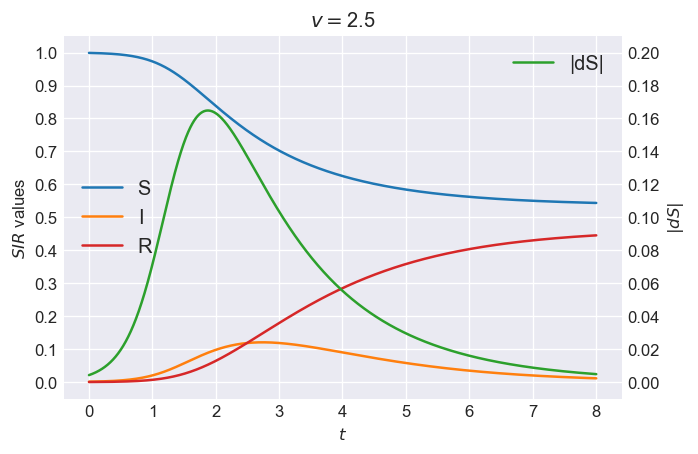

In [18]:
v0=2.5
r0=4.2
I0=0.001
S,I,R,dS= getSIRdS(r0,I0,v0)

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S, color='C0', label=f'S')
plt.plot(m_t, I,color='C1', label=f'I')
plt.plot(m_t, R,color='C3', label=f'R')
ax.set_ylim([-0.05,1.05])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$SIR$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, dS, color='C2', label=f'|dS|') 
ax2.set_ylim([-0.01,0.21])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax2.grid(False)
ax2.set_ylabel(f'$|dS|$')
plt.legend(loc='upper right')
plt.title(f'$v=${v0}')

plt.show() 



How many has ever been infected at the maximum of the infection rate $|dS/dt|$? 

In [19]:
print(f'R+I at max |dS/dt| is {(R+I)[np.argmax(dS)]}.')

R+I at max |dS/dt| is 0.14123151973121095.


For $v_0=2.5$ infection rate peaked at 14% of the population has been ever infected. Let's call the percentage of the population has been ever infected (i.e. $R+I$) at infection rate peak as peaked infected percent or PIP.

Next we try to find $v_0$ so that PIP is equal 10%.

In [20]:
goal=0.1
guess=3.0
def cost_f(v):
    _,I,R,dS= getSIRdS(r0,I0,v[0])
    v=(R+I)[np.argmax(dS)]
    return (v-goal)**2
m=minimize(cost_f,guess,method='Powell',tol=0.001)
print(f'PIP is equal 10% when v0 is {m.x}')

PIP is equal 10% when v0 is [3.32651562]


So total inhomogeneity of the population described by  $v_0$ must be equal 3.33. How soundness this figure we can see calculating appropriate ratios.

In [21]:
D0=3.33
r,rs,rb=get_range(v0)
print(f'ratio of top 10% to low 10% for v0={v0} is {r},\nrs={rs} and rb={rb} (equally divded)')

ratio of top 10% to low 10% for v0=2.5 is 57.548144094658774,
rs=17.56022527907195 and rb=17.56022527907195 (equally divded)


27 as ratio of top 10% to low 10% for social contacts rate seems to me possible although 20 seems more reasonable. Let's try 20 and see what happens with biological inhomogeneity.

In [22]:
r,rs,rb=get_range(v0,20.0)
print(f'ratio of top 10% to low 10% for v0={v0} is {r},\nif rs={rs} then rb={rb} ')

ratio of top 10% to low 10% for v0=2.5 is 57.548144094658774,
if rs=20.0 then rb=15.322870194375646 


How sound biological inhomogeneity to COVID-19 presuming top 10% to bottom 10% ratio of 27 or even 36? From one hand it is a big range. On the other hand we know that some ill patients have no symptoms at all, others soon painfully dies. So COVID-19 acts really different on individuals and it is possible that biological ability to catch the decease also greatly varies.

Also there are the articles showing that the individuals ability to spread COVID-19 substantioanally differs:
https://www.sciencemag.org/news/2020/05/why-do-some-covid-19-patients-infect-many-others-whereas-most-don-t-spread-virus-all

https://www.theatlantic.com/health/archive/2020/09/k-overlooked-variable-driving-pandemic/616548/

Anyway using our model we draw some usefull dependencies for $v_0$, $r_s$,$r_b$.

In [23]:
def PIP(r0,I0,Drange):
    def F(d):
        _,I,R,dS=getSIRdS(r0,I0,d)
        return (R+I)[np.argmax(dS)]
    return 100*np.vectorize(F,otypes=[float])(Drange)

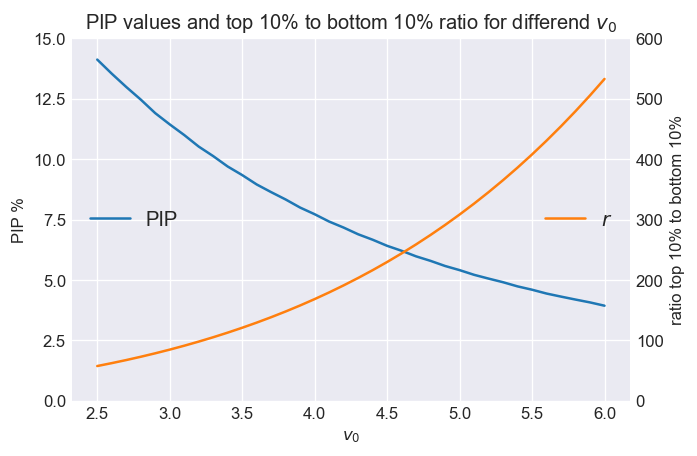

In [24]:
v_r=np.arange(2.5,6.1,0.1)
r,_,_=get_range(v_r)
pip=PIP(r0,I0,v_r)
fig, ax = plt.subplots(dpi=120)
plt.plot(v_r,pip, color='C0', label=f'PIP')
ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.set_ylim([0,15])
ax.set_ylabel(f'PIP %')
plt.xlabel(f'$v_0$')
plt.legend(loc='center left')
ax2 = ax.twinx()
plt.plot(v_r,r, color='C1', label=f'$r$') 
ax2.set_ylim([0,600])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax2.grid(False)
ax2.set_ylabel('ratio top 10% to bottom 10%')
plt.legend(loc='center right')
plt.title(f'PIP values and top 10% to bottom 10% ratio for differend $v_0$')
plt.show() 


Now look at the ratios of biological and social inhomogeneity for different PIP values

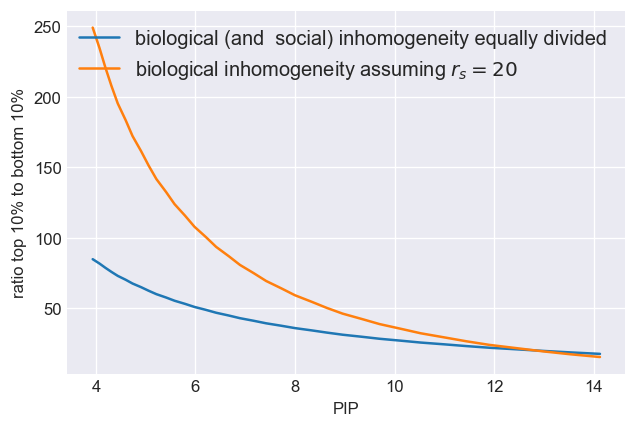

In [25]:
_,rs,_=get_range(v_r)
_,_,rb=get_range(v_r,20.0)
fig, ax = plt.subplots(dpi=120)
plt.plot(pip,rs, color='C0', label=f'biological (and  social) inhomogeneity equally divided')
plt.plot(pip,rb, color='C1', label=f'biological inhomogeneity assuming $r_s=20$')
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
#ax.set_ylim([-0.05,1.05])
ax.set_ylabel(f'ratio top 10% to bottom 10%')
plt.legend()
plt.xlabel(f'PIP')
plt.show() 


PS To get the Laplace transform of lognormal variable by direct integration there is the much faster version:

In [26]:
def LaplTrLNFast(u,mu0,v0):
    '''
    fast version of direct integration
    '''
    max_exp=700.0 # np.exp(max_exp) - maximal double value to calculate without overflow
    sm=np.sqrt(2.0*v0)
    def F(v,x): 
        y=x**3+x
        z=sm*y+mu0
        s=np.exp(np.where(z<max_exp,z,max_exp))*v+y**2
        return np.exp(-s)*(3.0*x**2+1.0)
    v=np.atleast_1d(u)[None,:]
    step=5.5/512.0
    lb=-250.5*step
    x=np.arange(lb,0.0,step)[:,None]
    res=(sm*step/np.sqrt(2.0*np.pi*v0))*np.sum(F(v,-x)+F(v,x),axis=0)
    if len(res)==1:return res[0]
    return res

I have found the idea behind here 
    https://www.sciencedirect.com/science/article/pii/S0167668719303993
and it is rooted in this article
Takahasi, H. and Mori, M. (1974). Double exponential formulas for numerical integration. Publ. RIMS Kyoto Univ, 9:721-741.

Still it is much more computational expensive compared to proposed alternative approach.
        